# Setup

In [1]:
# Python >=3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >=0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
assert pd.__version__ >= "0.25"
import seaborn as sns
import numpy as np
import os

# to make this notebook's output stable
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "loan"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", 
             resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Business Understanding

Among all industries, the insurance domain has one of the largest uses of analytics & data science methods. This project is to answer "Should This Loan be Approved or Denied?". From a company's perspective, you want to minimize the risk of not getting money back and of losing possible customers; thus, it brings the importance of this project. By nature of question, this problem is binary classification problem. 

#### The Problem is: predict if a loan will get approved or not.
`note`: I will follow CRISP-DM

# Data Aquisition

In [2]:
df = pd.read_csv('loan-prediction.csv')

In [3]:
df.shape

(614, 13)

#### VARIABLE DESCRIPTIONS:

|Variable	    |      Description|
|-------------:|:----------------|
|Loan_ID	    |  Unique Loan ID |
|Gender	        |   Male/ Female |
|Married	    |  Applicant married (Y/N)|
|Dependents	    |      Number of dependents|
|Education	    |      Applicant Education (Graduate/ Under Graduate)|
|Self_Employed	|          Self employed (Y/N)|
|ApplicantIncome |	          Applicant income|
|CoapplicantIncome|	  Coapplicant income|
|LoanAmount	      |    Loan amount in thousands|
|Loan_Amount_Term |	  Term of loan in months|
|Credit_History	  |        credit history meets guidelines|
|Property_Area	  |        Urban/ Semi Urban/ Rural|
|Loan_Status	  |        Loan approved (Y/N)|

Our target (response) is `Loan_Status`. 

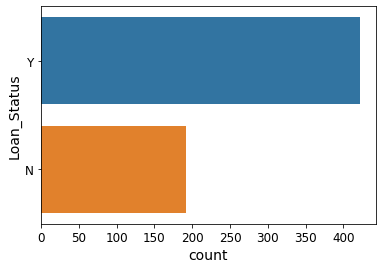

In [4]:
sns.countplot(y="Loan_Status",  data=df);

Okay, the data is off-balanced and we need to split the dataset into training and test sets so the training set reflects the distribution of target values because if we do not consider the imbalance between two classes and split the dataset randomly, we automatically embrace the risk of model learning not "realistic" data. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Loan_Status"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop(columns=['Loan_Status'])
y_train = strat_train_set['Loan_Status'].values
X_test = strat_test_set.drop(columns=['Loan_Status'])
y_test = strat_test_set['Loan_Status'].values

y_train = np.where(y_train == 'Y', 1, 0)
y_test = np.where(y_test == 'Y', 1, 0)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((491, 12), (123, 12), (491,), (123,))

# Data Undestanding

In [7]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [8]:
X_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001535,Male,No,0,Graduate,No,3254,0.0,50.0,360.0,1.0,Urban
1,LP001792,Male,Yes,1,Graduate,No,3315,0.0,96.0,360.0,1.0,Semiurban
2,LP002443,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural
3,LP002517,Male,Yes,1,Not Graduate,No,2653,1500.0,113.0,180.0,0.0,Rural
4,LP001894,Male,Yes,0,Graduate,No,2620,2223.0,150.0,360.0,1.0,Semiurban


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 12 columns):
Loan_ID              491 non-null object
Gender               480 non-null object
Married              488 non-null object
Dependents           483 non-null object
Education            491 non-null object
Self_Employed        464 non-null object
ApplicantIncome      491 non-null int64
CoapplicantIncome    491 non-null float64
LoanAmount           471 non-null float64
Loan_Amount_Term     479 non-null float64
Credit_History       448 non-null float64
Property_Area        491 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 46.2+ KB


`Note`: 'Loan_Id' is an object and since all applicant have distinct ID this feature is useless for prediction. 

`Note`: that 'Credit_History' is actually categorical but it is numerical here.

In [10]:
X_train.isnull().sum()

Loan_ID               0
Gender               11
Married               3
Dependents            8
Education             0
Self_Employed        27
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term     12
Credit_History       43
Property_Area         0
dtype: int64

We have some data loss in a few features. We will have to deal with missing values later.

In [11]:
X_train.isnull().sum() / df.shape[0] * 100

Loan_ID              0.000000
Gender               1.791531
Married              0.488599
Dependents           1.302932
Education            0.000000
Self_Employed        4.397394
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.257329
Loan_Amount_Term     1.954397
Credit_History       7.003257
Property_Area        0.000000
dtype: float64

The damage appears to be not too severe. 

## EDA on numerical features

### Dealing with missing values
Recall that we had missing values in `LoanAmount` feature of 3.26% (20 counts). Given the transformed feature distribution, which is normal, either mean, median or mode does not change difference. Other two numerical featuers - ApplicantIncome and CoaaplicantIncome - do not have missing values.

In [12]:
# drop 'Loan_ID'
X_train.drop(columns=['Loan_ID'], inplace=True)

In [13]:
num_df = X_train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]
cat_df = X_train[np.setdiff1d(X_train.columns, num_df.columns)]

In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

num_arr = imputer.fit_transform(num_df)

In [15]:
np.isnan(num_arr).sum()

0

No missing values. Very good.

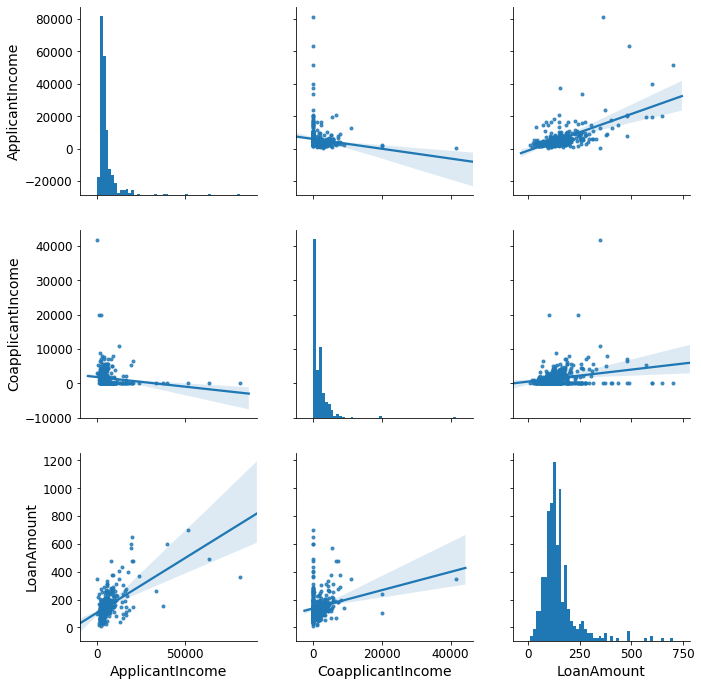

In [16]:
num_df = pd.DataFrame(num_arr, columns=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'])

g =sns.pairplot(num_df, kind='reg', markers=".",diag_kws=dict(bins=50))
g.fig.set_size_inches(10,10)

- ApplicantIncome is heavily right-skewed. Most people's income lie in lower range. 
- CoapplicanIncom distribution resembles that of ApplicanIncome except that it seems bimodal. One peak at 0. 
- LoanAmount is also right-skewed and most amount ranges between 0 to 250k. 

All in all, our goal is keep original distributions as intact as possible but make them useful and easy for the model to predict the response accurately. One mega-theme we can discover here is all features have **high leverage points** or outliers. It would be nice to have them on a same/similar scale and minimize the degree of leverage of outliers.  

In light of this, we consider **quantile transform**. The following is excerpted from [scikit-learn][sklearn] page:

> Quantile transform method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.
>
> The transformation is applied on each feature independently. First an estimate of the cumulative distribution function of a feature is used to map the original values to a uniform distribution based on its rank. The obtained values are then mapped to the desired output distribution using the associated quantile function. Features values of new/unseen data that fall below or above the fitted range will be mapped to the bounds of the output distribution. Note that this transform is non-linear. It may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable.

[sklearn]: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer

In [17]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=len(num_df), output_distribution='normal')
num_scaled = qt.fit_transform(num_df)

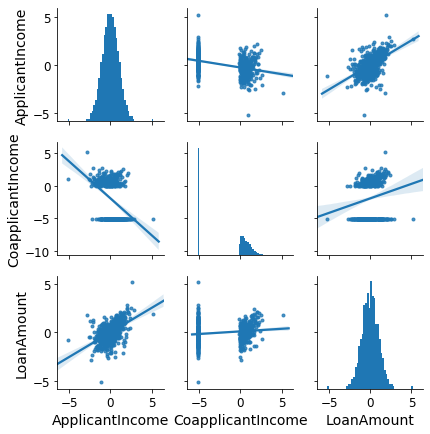

In [18]:
# to plot scaled data
num_df_scaled = pd.DataFrame(num_scaled, columns=num_df.columns)

g =sns.pairplot(num_df_scaled, kind='reg', markers=".",diag_kws=dict(bins=50))
g.fig.set_size_inches(6,6)

One problem is coapplicant is shaped as if it is categorical especially at '-5' (originally '0'). In this case nearly half of instances that are '-5' can have more effect on the result. The balance the leverage, let's move the data points so the mean is located at '0'

In [19]:
num_df_scaled[num_df_scaled['CoapplicantIncome'] <= -5]['CoapplicantIncome'].shape[0]

223

In [20]:
num_df_scaled[num_df_scaled['CoapplicantIncome'] > -5]['CoapplicantIncome'].shape[0]

268

In order to pipeline the process, we need to create a custom transformer

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class Move_CoapplicantIncome(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # Nothinng to do 
    def transform(self, X, y=None):
        X[:, 1] = X[:, 1] - X[:, 1].mean() # 'CoapplicantIncome'
        return X 

In [22]:
num_df_scaled = Move_CoapplicantIncome().transform(num_df_scaled.values)

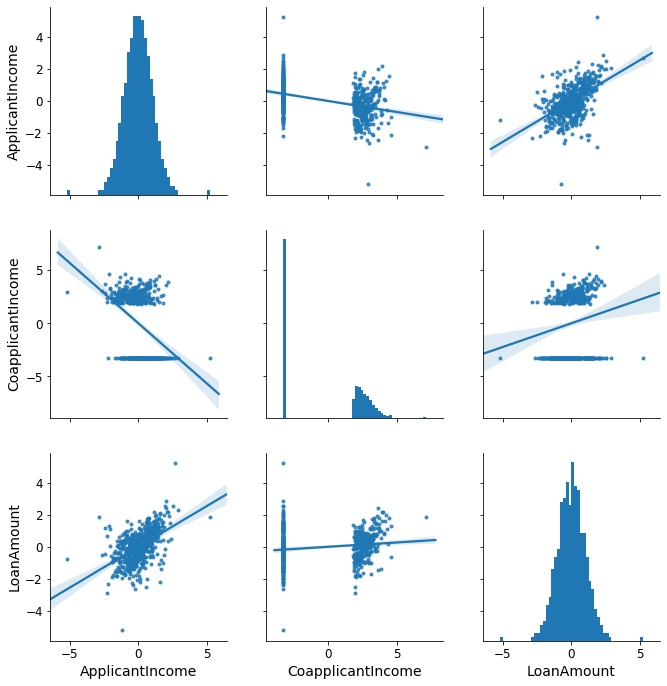

In [23]:
num_df_scaled = pd.DataFrame(num_df_scaled, columns=num_df.columns)

g =sns.pairplot(num_df_scaled, kind='reg', markers=".",diag_kws=dict(bins=50))
g.fig.set_size_inches(10,10)

Now all features are bound to [-5, 5] and it seems the transformation preserves the trait of original distribution including correlation between features. 

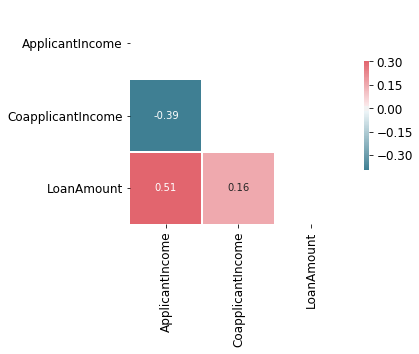

In [24]:
corr_matrix = num_df_scaled.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.autoscale();

Looking at correlation/collinearity between numerical features. ApplicanIncome and LoanAmount are positively correlated and ApplicanIncome and CoapplicanIncome is negatively correlated. These sound all reasonable so we wouldn't change a thing here.

## EDA on categorical features
Now look at the categorical features.

In [25]:
# for plotting purpose
cat_df_temp = pd.concat([cat_df, pd.DataFrame(y_train, columns=['Loan_Status'])], axis=1)

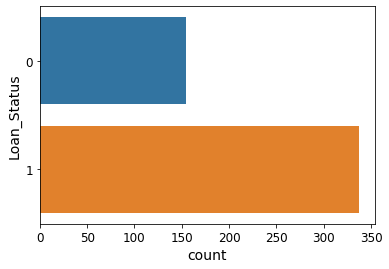

In [26]:
sns.countplot(y="Loan_Status", data=cat_df_temp);

Our train dataset is imbalanced. More than half seems approved. This can give us a hint which feature can play an important role because if this distribution-shape is too off in a certain attribute, that means that feature is eccentric and we need to give more attention. 

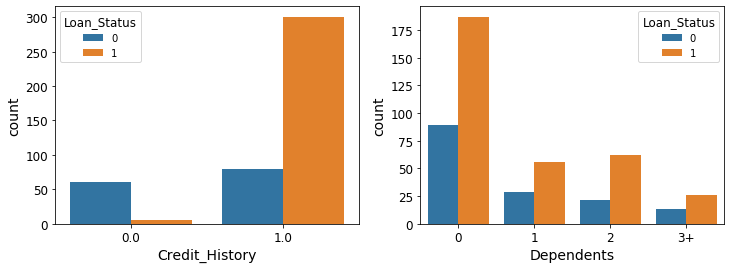

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.countplot(x="Credit_History", hue="Loan_Status", data=cat_df_temp)

plt.subplot(122)
sns.countplot(x="Dependents", hue="Loan_Status", data=cat_df_temp);

There are more people who meets the credit history guidline. Here, as I just mentioned, the distribution shape is fliped left-to-right at Credit_History 0, which may mean **credit history plays an important role in decision making**. We shall have to see whether it actually is once we have our model. The majority of applicants have no dependents. 

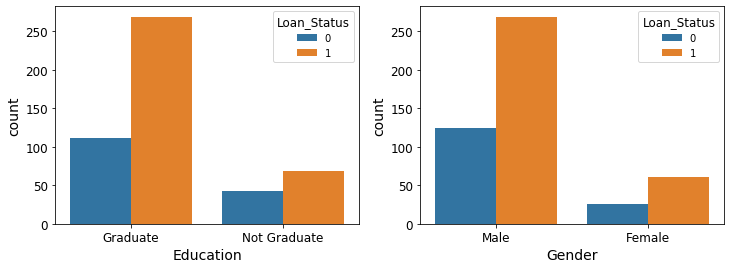

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.countplot(x="Education", hue="Loan_Status", data=cat_df_temp)

plt.subplot(122)
sns.countplot(x="Gender", hue="Loan_Status", data=cat_df_temp);

Most are gradautes and males. 

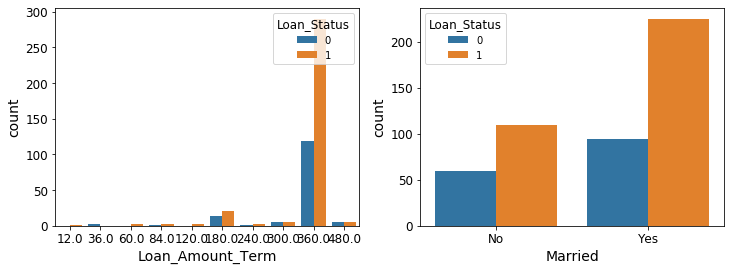

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.countplot(x="Loan_Amount_Term", hue="Loan_Status", data=cat_df_temp)

plt.subplot(122)
sns.countplot(x="Married", hue="Loan_Status", data=cat_df_temp);

Most people applied for 3 year (36 month) loan and are married. 

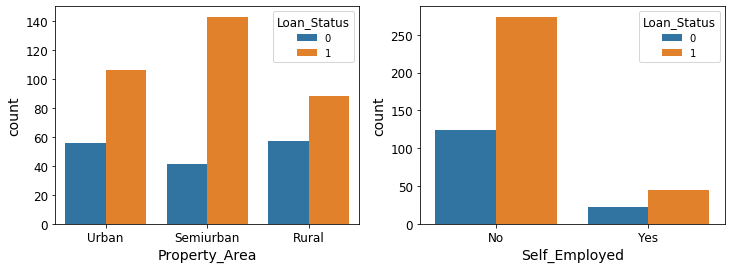

In [30]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.countplot(x="Property_Area", hue="Loan_Status", data=cat_df_temp)

plt.subplot(122)
sns.countplot(x="Self_Employed", hue="Loan_Status", data=cat_df_temp);

Compared to other features, it shows relatively well balanced distribution of property area. Most people do not work for him/herself.

### Handling Categorical Attributes

In [31]:
cat_df['Property_Area'].unique()

array(['Urban', 'Semiurban', 'Rural'], dtype=object)

In [32]:
for column in cat_df.columns:
    print(f'{column}: {cat_df[column].unique()}')

Credit_History: [ 1.  0. nan]
Dependents: ['0' '1' '2' nan '3+']
Education: ['Graduate' 'Not Graduate']
Gender: ['Male' 'Female' nan]
Loan_Amount_Term: [360. 180.  nan  84. 300. 240.  60. 480.  12. 120.  36.]
Married: ['No' 'Yes' nan]
Property_Area: ['Urban' 'Semiurban' 'Rural']
Self_Employed: ['No' 'Yes' nan]


Okay, all attributes have ~11 categories in which case one-hot encoding is reasonable. 

In [33]:
cat_df.isnull().sum() / len(cat_df) * 100

Credit_History      8.757637
Dependents          1.629328
Education           0.000000
Gender              2.240326
Loan_Amount_Term    2.443992
Married             0.610998
Property_Area       0.000000
Self_Employed       5.498982
dtype: float64

Besides 'Credit_History' most missing values take up less than 5% of the entire data points. We could predict the Credit_History with other features, but since most applicants belong to "1" we might as well assign those missing values to "1" which is most dominantly frequent class. Likewise, most features show vivid contrast among its categories, so we can assign missing values to most frequent classes. 

In [34]:
class To_Category(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # Nothinng to do 
    def transform(self, X, y=None):
        return X.astype('category')

cat_df = To_Category().transform(cat_df)

cat_df.describe()

,Credit_History,Dependents,Education,Gender,Loan_Amount_Term,Married,Property_Area,Self_Employed
count,448.0,483,491,480,479.0,488,491,464
unique,2.0,4,2,2,10.0,2,3,2
top,1.0,0,Graduate,Male,360.0,Yes,Semiurban,No
freq,381.0,276,380,393,409.0,319,184,398


Let's impute missing values with 'mode'

In [35]:
imputer = SimpleImputer(strategy="most_frequent")

cat_df = imputer.fit_transform(cat_df)

In [36]:
imputer.statistics_

array([1.0, '0', 'Graduate', 'Male', 360.0, 'Yes', 'Semiurban', 'No'],
      dtype=object)

Now let's convert categorical features to one-hot binary features.

In [37]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
cat_1hot = cat_encoder.fit_transform(cat_df)
cat_1hot

array([[0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.]])

In [38]:
cat_1hot.shape  # 2 + 4 + 2 + 2 + 10 + 2 + 3 + 2 = 27

(491, 27)

# Data Preparation
### Pipeline-ing Preprocessing
Pipe line the process we did until now.

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('qt_scaler', QuantileTransformer(n_quantiles=len(num_df), output_distribution='normal')),
    ('Move_CoapplicantIncome', Move_CoapplicantIncome())
])

cat_pipeline = Pipeline([
    ('To_Category', To_Category()),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])

num_attribs = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
cat_attribs = ['Credit_History', 'Dependents', 'Education', 'Gender',
               'Loan_Amount_Term', 'Married', 'Property_Area', 'Self_Employed']

preprocessing_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
X_train_prepared.shape

(491, 30)

Hooray! We've just finished the data preparation. Let's move onto modeling!

# Modeling

## Evaluation Metric Selection

Before we jump to model selection. We have to decide with which metric we evaluate the model. First, we need to think about what is meaningful. There are two risks that company has to carry: **wrongly rejecting a loan and wrongly approving a loan. The former is False Negative (FN; Type II error)** and **the latter is False Positive (FP; Type I error)**. From a business perspective, both errors mean losing money -  one with losing possible customer and the other one with not getting money back. Which means we need to factor **both recall and precisionn** into. However what is important is **we do not care about True Negative**. In this sense, **`Average Precision` (PR)** suits the task more than ROC AUC (Area Under the Receiver OPerating Characteristic Curve) score. Because the difference between PR and ROC AUC is in how each treats TN. According to the definitions of terms (reference below) **`PR does not take TN into calculation`** while ROC AUC does. Also, one might wonder "why not F score if you care about precision and recall together?. My answer to using Average Precision is Ap is more accurate than the F score because it considers the PR relation globally. 

$$
\begin{align}
&TPR \hspace{0.05in}(Recall) &=& \quad \frac{TP}{TP + FN} \\
&Precision &=& \quad \frac{FP}{TP+FP} \\
&FPR &=& \quad \frac{FP}{TN+FP} \\
&AP &=& \quad \sum_n (R_n - R_{n-1}) P_n&
\end{align}
$$

Where TPR stands for True Positive Rate and FPR False Positive Rate. $R_n$ and $P_n$ are the precision and recall at the $nth$ threshold

## Model Selection

From what I observed in EDA section - that numerical values follows the nomral distribution and that we use one-hot binary vectors for categorical features, **my initial impression is** simple model would not work well for the dataset and **more complex model would perform better**. However, to see this is valid impresson or not we will go over simple and complex models with default settings. However, due to the small size of dataset, too complex model might overfit the training set and perform poorly on the test set. Once we get a better grasp on which model performs better we will go further to fine-tune the model from there. The following are the models I will try:

- Linear SVM (LSVM)
- Logistic Regression (LR)
- Naive Bayes (NB)
- Linear Discriminant Analysis (LDA)
- Quadratic Discriminant Anlaysis (QDA)
- K Nearest Neighbors (KNN)
- Random Forest (RF)
- Kernel SVM (SVM)
- Extreme Gradient Boost (XGB)

In [41]:
def warn(*args, **kwargs): # force sklearn to shut off warning on LDA
    pass
import warnings
warnings.warn = warn

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [42]:
# we need to convert 

models = []
models.append(('LSVM', LinearSVC(random_state=42)))
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('SVM', SVC(gamma='scale', random_state=42)))
models.append(('XGB', xgb.XGBClassifier()))

results = []
names = []
kfold = KFold(n_splits=6, random_state=42)

for name, model in models:
    cv_results = cross_val_score(model, X_train_prepared, y_train,
                                 cv=kfold, scoring="average_precision")
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})"
    print(msg)

LSVM: 0.7821 (0.0944)
LR: 0.7883 (0.0838)
NB: 0.7866 (0.0929)
LDA: 0.7887 (0.0840)
QDA: 0.7868 (0.0917)
KNN: 0.7839 (0.0503)
RF: 0.8080 (0.0669)
SVM: 0.8402 (0.0583)
XGB: 0.8270 (0.0804)


Alright. I was right on anticipation that complex model would work better given that we have high sparcity due to one-hot binary vectors and numerical features are normally distributed closely. We will choose top-2 learners (XGB, SVM) and fine tune to see the improvement.  

## Fine-Tuning the Model (XGB)

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(n_jobs=[16],
                  n_estimators=[25, 50, 100],
                  objective=['binary:logistic', 'rank:map'],
                  learning_rate = [0.025, 0.05, 0.075],
                  max_depth = [4, 5, 6],
                  subsample = [0.5, 0.6, 0.8, 1],
                  colsample_bytree = [0.6, 0.7, 0.8, 1],
                  reg_alpha = [0, 0.5, 1],
                  reg_lambda = [0, 1, 3, 5])
    
xgboost = xgb.XGBClassifier(random_state=42, verbose=1)

grid_search = GridSearchCV(xgboost, param_grid, cv=6,
                        scoring='average_precision', return_train_score=True)

grid_search.fit(X_train_prepared, y_train);

In [44]:
xgb_grid_search.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 25,
 'n_jobs': 16,
 'objective': 'binary:logistic',
 'reg_alpha': 0.5,
 'reg_lambda': 0,
 'subsample': 0.6}

In [45]:
xgb_grid_search.best_score_

0.868621589142343

In [46]:
xgboost = xgb_grid_search.best_estimator_

## Fine-Tuning the Model (SVM)

In [47]:
C = [0.05, 0.1, 1, 5]
Gamma = ['auto', 0.01, 0.05, 0.1, 0.5, 1, 5, 10]

param_grid = [
        dict(C=C, kernel=['rbf'], gamma=Gamma),
#         dict(C=C, kernel=['poly', 'sigmoid'], gamma=Gamma, degree=[2, 3, 4, 5], coef0=[-5, -2.5, 0, 2.5, 5])
    ]
    
svm = SVC(probability=True, random_state=42)

svm_grid_search = GridSearchCV(svm, param_grid, cv=6,
                        scoring='average_precision', return_train_score=True)

svm_grid_search.fit(X_train_prepared, y_train);

In [48]:
svm_grid_search.best_params_

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}

In [49]:
svm_grid_search.best_score_

0.8471737468378827

In [50]:
svm = svm_grid_search.best_estimator_

# Evaluation

### XGB

In [53]:
X_test_prepared = preprocessing_pipeline.transform(X_test)

y_pred_xgb = xgboost.predict(X_test_prepared)

In [55]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

average_precision_xgb = average_precision_score(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

In [56]:
print("Result with XGBoost on test set:")
print(f"Average Precision: {average_precision_xgb: .4f}")
print(f"Accuracy: {accuracy_xgb: .4f}")

Result with XGBoost on test set:
Average Precision:  0.8300
Accuracy:  0.8537


### SVM

In [57]:
y_pred_svm = svm.predict(X_test_prepared)

In [58]:
average_precision_svm = average_precision_score(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

In [59]:
print("Result with SVM on test set:")
print(f"Average Precision: {average_precision_svm: .4f}")
print(f"Accuracy: {accuracy_svm: .4f}")

Result with SVM on test set:
Average Precision:  0.8300
Accuracy:  0.8537


Wow, I have mixed feelings. For one hand, we improved the AP score upto 0.85 and on the other hand, both optimal XGB and SVM models give the same results for average precision and accuracy! Which seems there are very ambiguous mixed-up area where it is very hard to decide to which class an instance belongs. Since it is pretty high dimensional (degree of 30), in order to show the data, we will have to do some dimension reduction for visualization. For this purpose, I will use t-SNE. The reason why I use t-SNE is t-SNE takes high dimensional data and preserves the originnal data configuration based on similarity in original dimension. Therefore, it is a good way to grasp original data configuration as closely as possible in the low dimension such as 3D we can perceive. Let us check my evaluation is valid.

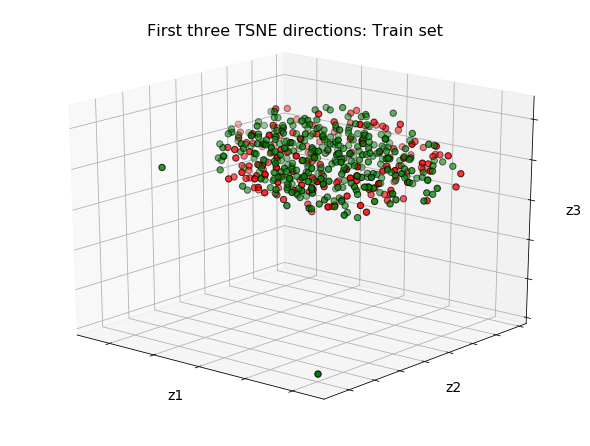

In [60]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

approved_idx = np.squeeze(np.argwhere(y_train))
rejected_idx = np.squeeze(np.argwhere(y_train-1))

tsne = TSNE(n_components=3, init='random', random_state=42)
Z = tsne.fit_transform(X_train_prepared)

# To getter a better understanding of interaction of the dimensions
# plot the first three t-SNE dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=20, azim=130)

ax.scatter(Z[approved_idx, 0], Z[approved_idx, 1], Z[approved_idx, 2], 
           c='g', cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.scatter(Z[rejected_idx, 0], Z[rejected_idx, 1], Z[rejected_idx, 2], 
           c='r', cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three TSNE directions: Train set", fontsize=16)
ax.set_xlabel("z1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("z2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("z3")
ax.w_zaxis.set_ticklabels([]);

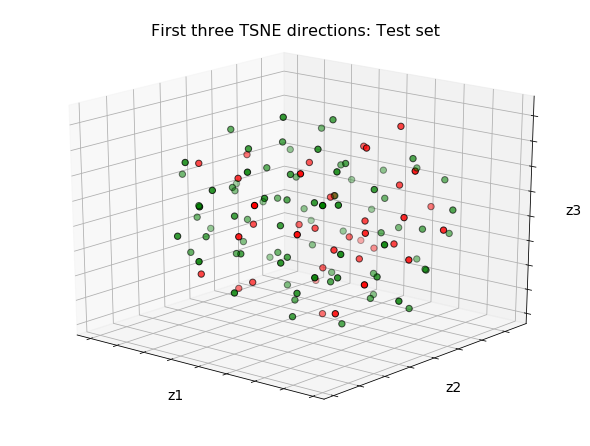

In [61]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

approved_idx = np.squeeze(np.argwhere(y_test))
rejected_idx = np.squeeze(np.argwhere(y_test-1))

tsne = TSNE(n_components=3, init='random', random_state=42)
Z = tsne.fit_transform(X_test_prepared)

# To getter a better understanding of interaction of the dimensions
# plot the first three t-SNE dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=20, azim=130)

ax.scatter(Z[approved_idx, 0], Z[approved_idx, 1], Z[approved_idx, 2], 
           c='g', cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.scatter(Z[rejected_idx, 0], Z[rejected_idx, 1], Z[rejected_idx, 2], 
           c='r', cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three TSNE directions: Test set", fontsize=16)
ax.set_xlabel("z1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("z2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("z3")
ax.w_zaxis.set_ticklabels([]);

So indeed this is a hard problem the data is very muddy and any data point could seemingly be assigned to any classes but now 83% of precision and 85% sound like a big achievement because with this no-clear-cut-boundary-existing data human can easily make mistakes. 

So, it turns out both SVM and XGBoost classifiers did their best. Looking at the data configuration and there being many categorical features, decision tree base model should work well because it resembles how any agents would come to conclusion! Since SVM used 'rbf' kernel which can be unfold into infinit dimension in feature space, with good hyperparameters, it ought to perform well as well. 

Now let us see the feature importance with XGBoost since kernel svm does not provide a way for it. 

### Feature Importance

With kernel SVM we can't extract feature importance, but XGB can. Therefore, with the help of XGB, let us see which feature contributes to decision making. 

In [62]:
feature_map = dict(
        f0 = 'ApplicantIncome',
        f1 = 'CoapplicantIncome',
        f2 = 'LoanAmount',
        f3 = 'Credit_History_1',
        f4 = 'Credit_History_0',
        f5 = 'Dependents_0',
        f6 = 'Dependents_1',
        f7 = 'Dependents_2',
        f8 = 'Dependents_3+',
        f9 = 'Education_Gradute',
        f10 = 'Educationn_Not_Graduate',
        f11 = 'Gender_Male',
        f12 = 'Gender_Female',
        f13 = 'Loan_Amount_Term_360',
        f14 = 'Loan_Amount_Term_180',
        f15 = 'Loan_Amount_Term_84',
        f16 = 'Loan_Amount_Term_300',
        f17 = 'Loan_Amount_Term_240',
        f18 = 'Loan_Amount_Term_60',
        f19 = 'Loan_Amount_Term_480',
        f20 = 'Loan_Amount_Term_12',
        f21 = 'Loan_Amount_Term_120',
        f22 = 'Loan_Amount_Term_36',
        f23 = 'Married_No',
        f24 = 'Married_Yes',
        f25 = 'Property_Area_Urban',
        f26 = 'Property_Area_Semiurban',
        f27 = 'Property_Area_Rural',
        f28 = 'Self_Employed_No',
        f29 = 'Self_Employed_Yes'
)

feature_importances = dict((feature_map[key], value) 
                           for (key, value) 
                           in xgboost.get_booster().get_score(importance_type="gain").items())

Here it begs some explanation on how I retrieved the feature importance. Basically, XGB provides importance but with many types ("gain", "weight", "cover", "total_gain", "total_cover") but I chose "Gain" as a type. 

The "Gain" implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction 

"Gain" is the improvement in accuracy brought by a feature to the branches it is on. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate (one branch saying if your observation is on this branch then it should be classified as 1, and the other branch saying the exact opposite).

For this reason the "Gain" is the most relevant attribute to interpret the relative importance of each feature.

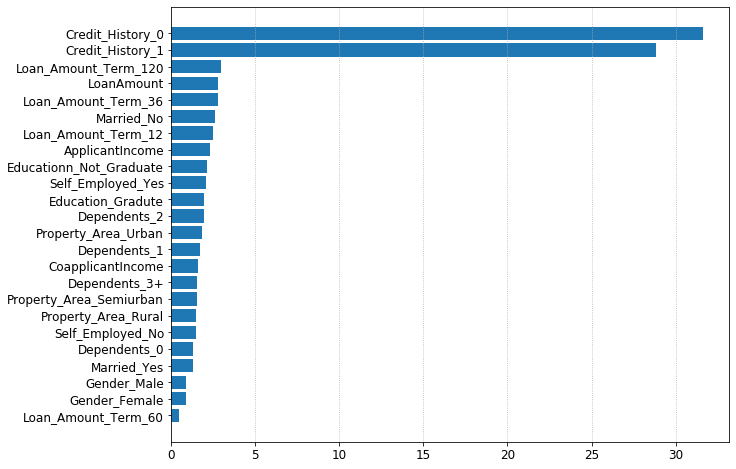

In [63]:
def plot_importances(names, imp):
    plt.figure(figsize=(10, 8))
    imp, names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.gca().xaxis.grid(True, linestyle=':')
    plt.show()
    
names = list(feature_importances.keys())
imp = list(feature_importances.values())
plot_importances(names, imp)

Again, as I observed Credit history is a much more important player by a lot. Basically, it seems like a single most important feature to decide weather a person gets approved or not for a loan. Other features contribute to decision making but it seems they are the ones who decide the marginal part of it thus it would be advisable based on the result that first look at the credit history and see other attributes such as loan amount, applicant income or loan terms to improve the accuracy. 

Let us see the summary of Precision and Recall with PR plot and confusion matrix. 

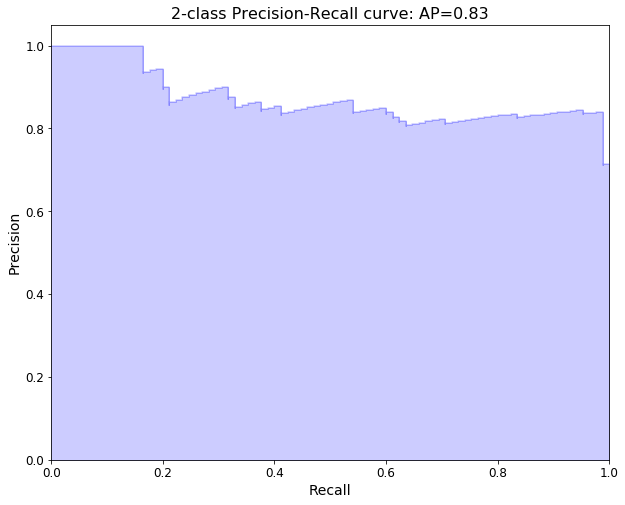

In [64]:
from sklearn.metrics import precision_recall_curve
from inspect import signature

y_test_proba = xgboost.predict_proba(X_test_prepared)

precision, recall, _ = precision_recall_curve(y_test, y_test_proba[:, 1])

plt.figure(figsize=(10, 8))
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'2-class Precision-Recall curve: AP={average_precision_xgb:0.2f}', fontsize=16)
plt.show();

Here, this precision-recall curve conlidate the idea that indeed there is no clear cut for classification between twoo classes. Usually, as recall score increases precision score goes down, so called suffering precision-recall tradeoff when there exists well-defined boundary between classes. However, again as we confimred in the above figure, all data is jumbled together therefore, we see rather flat curve in precision-recall graph. 

In [65]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    > Parameters:
    cm: confusion matrix(y_test, y_predicted)
    normalize: whether to normalize
    title: title of plot
    cmap: color map
    
    > Returns: None
    """    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
#     plt.tight_layout()
    plt.autoscale();
    plt.show();

Confusion matrix, without normalization
[[21 17]
 [ 1 84]]


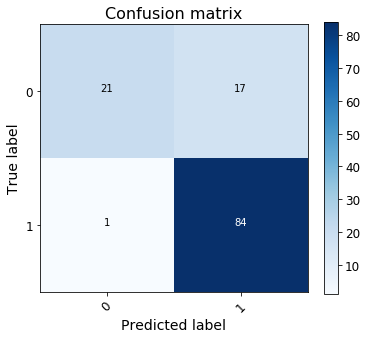

In [66]:
## compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_xgb)
np.set_printoptions(precision=2)

class_names = xgboost.classes_

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

You can read confusion matrix as follows:

|                       |Predicted '*No*' |Predicted '*Yes*'|
|-----------------------|:---------------:|:---------------:|
| **Actual** **'*No*'** |    TN           |      FP         |
| **Actual** **'*Yes*'**|    FN           |      TP         |


According to the confusion matrix, the model did great job on filtering out False Negative (FN) but did relatively poorly False Positive (FP). In other words, the model is less likely to reject promissing customers but susceptible to approving loans for risky customers therefore, vulnerable to type I errors. If this model is to be in production, agents who uses the model would want to go over applications approved to reduce the risk of approving the wrong person. To improve the model, I have a couple ideas:

1. Consult experts on possible questions (features) that can be added to application.
2. Collect more data
3. If we have enough data (e.g., 50,000+), we could try more complex model (e.g., Neural Network) 